Compare result from laserfun and pynlo

0.5917558222548732
   0.5% - 5.025e-05 m - 0.0 seconds
   1.0% - 1.005e-04 m - 0.0 seconds
   1.5% - 1.508e-04 m - 0.0 seconds
   2.0% - 2.010e-04 m - 0.0 seconds
   2.5% - 2.513e-04 m - 0.0 seconds
   3.0% - 3.015e-04 m - 0.0 seconds
   3.5% - 3.518e-04 m - 0.0 seconds
   4.0% - 4.020e-04 m - 0.0 seconds
   4.5% - 4.523e-04 m - 0.0 seconds
   5.0% - 5.025e-04 m - 0.0 seconds
   5.5% - 5.528e-04 m - 0.0 seconds
   6.0% - 6.030e-04 m - 0.1 seconds
   6.5% - 6.533e-04 m - 0.1 seconds
   7.0% - 7.035e-04 m - 0.1 seconds
   7.5% - 7.538e-04 m - 0.1 seconds
   8.0% - 8.040e-04 m - 0.1 seconds
   8.5% - 8.543e-04 m - 0.1 seconds
   9.0% - 9.045e-04 m - 0.1 seconds
   9.5% - 9.548e-04 m - 0.1 seconds
  10.1% - 1.005e-03 m - 0.1 seconds
  10.6% - 1.055e-03 m - 0.1 seconds
  11.1% - 1.106e-03 m - 0.1 seconds
  11.6% - 1.156e-03 m - 0.1 seconds
  12.1% - 1.206e-03 m - 0.1 seconds
  12.6% - 1.256e-03 m - 0.1 seconds
  13.1% - 1.307e-03 m - 0.1 seconds
  13.6% - 1.357e-03 m - 0.1 seconds
  14.1% -

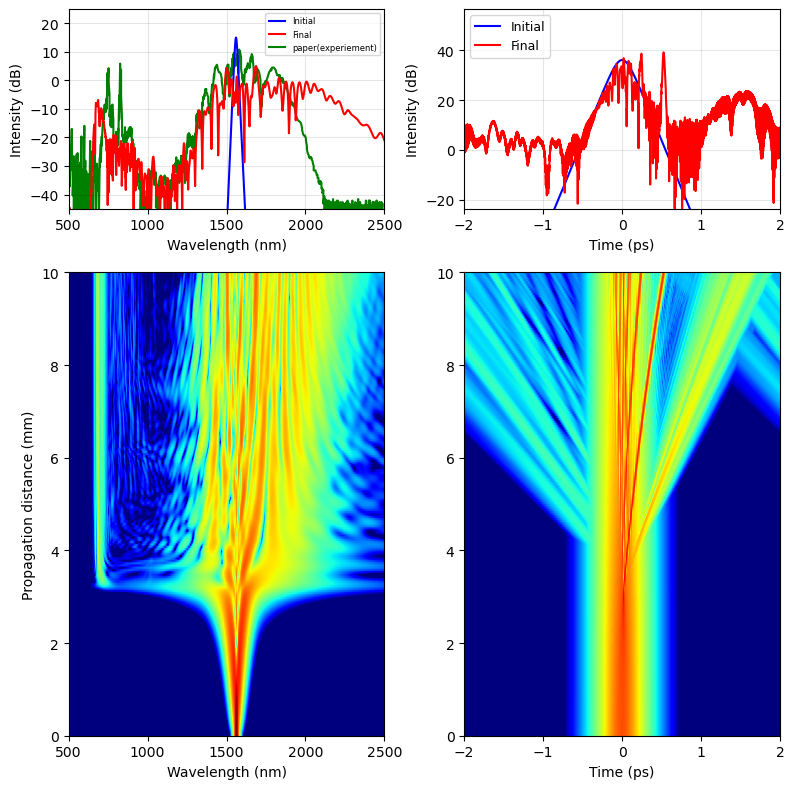

<Figure size 640x480 with 0 Axes>

In [5]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 200 * 1e-3  # pulse duration (ps)
pulseWL = 1560  # pulse central wavelength (nm)
length = 10 *1e-3

power = 4000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion
rep_rate = 80 * 1e6 # rep rate in hz
# simulation parameters
Window = 4  # simulation window (ps)
Steps = 200  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4 # absolute error
Raman = True  # Enable Raman effect?
Steep = True  # Enable self steepening?

ray = "o"
top_width = 1.15  # um
box_height = 5
triangle_height = 0.6
# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.16  # loss (dB/cm)

data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
wls = data['wls']
neff_list = data['neff_list_te']
aeff_list = data['aeff_list_te']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma

print(gamma_function(pulseWL))

# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, power=power, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)
p.add_noise()
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
###
fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(500, 2500), units="dB",rep_rate= rep_rate, cparam = [50, 60])

#------------- Plot reference -----------
ref = pd.read_csv(
    "../reference_data/Figure4a.csv", dtype=np.float64
)
ref_x, ref_y = np.split(ref.values, 2, axis=1)

axes[0][0].plot(ref_x, ref_y + 30, c="green", label="paper(experiement)", zorder=0)
axes[0][0].legend(loc="upper right", prop={'size': 6},fontsize=8)

plt.set_cmap('jet')
plt.show()

plt.set_cmap('jet')
plt.show()

0.5917558222548732


C:\Users\a1890865\AppData\Local\anaconda3\envs\SC-generation-stimulation\lib\site-packages\pynlo\model.py:617: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._rt_fig.show()
C:\Users\a1890865\AppData\Local\Temp\ipykernel_6680\1629000896.py:153: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10*np.log10(np.abs(a_t)**2)
C:\Users\a1890865\AppData\Local\Temp\ipykernel_6680\1629000896.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


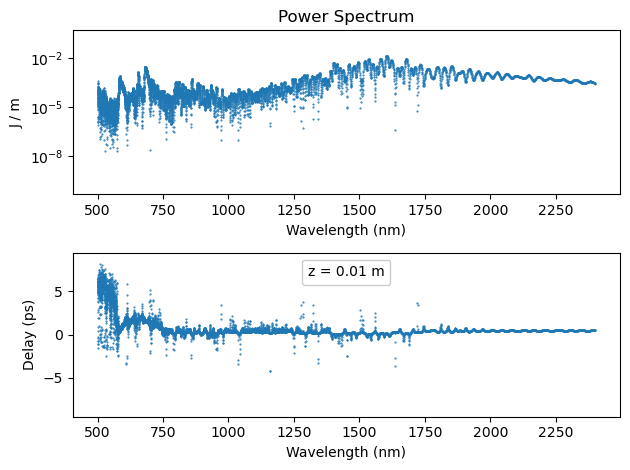

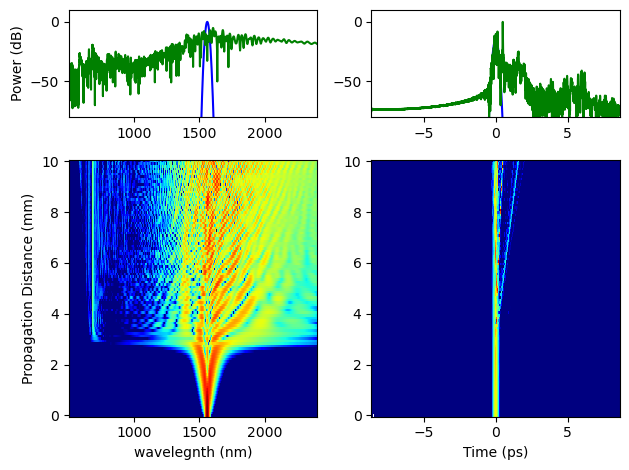

In [25]:
import numpy as np
import pynlo
from scipy.constants import pi, c
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt

import pynlo
from pynlo import utility as ut
def plot(pulse, z, a_t, a_v, xlim, ylim=None, tlim=None ):
    w_grid = c/(pulse.v_grid)*1e9
    fig = plt.figure("Simulation Results", clear=True)
    ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
    ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

    p_v_dB = 10*np.log10(np.abs(a_v)**2)
    p_v_dB -= p_v_dB.max()

    ax0.plot(w_grid, p_v_dB[0], color="b")
    ax0.plot(w_grid, p_v_dB[-1], color="g")
    ax2.pcolormesh(w_grid, 1e3*z, p_v_dB, vmin=np.max(p_v_dB) - 50, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax0.set_ylim(np.max(p_v_dB[0]) - 100,np.max(p_v_dB[0]) + 10)
    ax1.set_ylim(np.max(p_v_dB[-1]) - 100,np.max(p_v_dB[-1]) + 10)
    ax0.set_xlim(left = xlim[0], right = xlim[1])
    ax2.set_xlabel('wavelegnth (nm)')

    p_t_dB = 10*np.log10(np.abs(a_t)**2)
    p_t_dB -= p_t_dB.max()
    ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b")
    ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
    ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB, vmin=np.max(p_v_dB) - 80, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax1.set_xlim(left = xlim[0], right = xlim[1])
    ax3.set_xlabel('Time (ps)')
    
    if ylim:
        ax0.set_ylim(bottom=ylim[0], top=ylim[1])
        ax1.set_ylim(bottom=ylim[0], top=ylim[1])
    
    if tlim:
        ax2.set_xlim(left = tlim[0], right = tlim[1])
        ax3.set_xlim(left = tlim[0], right = tlim[1])

    ax0.set_ylabel('Power (dB)')
    ax2.set_ylabel('Propagation Distance (mm)')
    fig.tight_layout()
    fig.show()
    
def dB(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)**2)

# Calculate Gamma

    
n_points = 2**13
center_wl = 1560 *1e-9
start_wl = 500 *1e-9
end_wl = 2400 *1e-9

pulse_duration = 200e-15
peak_power = 4000
e_p = peak_power * pulse_duration / 0.88   # energy per pulse in joules
t_fwhm = 200e-15    # for sech, fwhm = 1.76 * pulse duration 

f_min = c/(end_wl)   # c / l
f_max = c/(start_wl)    # c / l
f0 = c/center_wl       # c / 


pulse = pynlo.light.Pulse.Gaussian(n_points, f_min, f_max, f0,e_p, t_fwhm, alias=2) # alias = number of harmonic support by the real-valued time domain grid

'''
dbm = dB(pulse.a_v)
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax0.set_xlabel('frequency (THz)')
ax0.plot(1e-12*pulse.v_grid, dbm, color="b")
plt.show()
'''

data = np.load("data_h_0.6_w_1.15_o.npz")
wls = data['wls']* 1e-9
aeff_list = data['aeff_list_te']
neff_list = data['neff_list_te']

aeff_interp = scipy.interpolate.interp1d(wls,aeff_list)
neff_interp = scipy.interpolate.interp1d(wls,neff_list)

length = 10e-3 # 10 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c/pulse.v_grid 
n_eff = neff_interp(w_grid)
beta = n_eff * 2*pi*pulse.v_grid/c

#---- 2nd-order nonlinearity
d_eff = 4.3e-12 # 30 pm / V
chi2_eff = 2 * d_eff
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)


# 3rd-Order Nonlinearity
n2 = 1e-19
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * aeff_interp(pump_wl) * 1e-12)
    return gamma

gamma = gamma_function(center_wl) #1/(W*m)
print(gamma)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

'''
# Raman effect
r_weights = [0.245*(1-0.21), 12.2e-15, 32e-15] # resonant contribution
b_weights = [0.245*0.21, 96e-15] # boson contribution
rv_grid, raman = ut.chi3.raman(pulse.n, pulse.dt, r_weights, b_weights)
'''

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, g2=g2)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-4
dz = model.estimate_step_size(local_error=local_error)
    
pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot="wvl")

fig = plt.figure("Simulation Results", clear=True)
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

p_v_dB = 10*np.log10(np.abs(a_v)**2)
p_v_dB -= p_v_dB.max()

w_grid = c/(pulse.v_grid)*1e9
ax0.plot(w_grid, p_v_dB[0], color="b")
ax0.plot(w_grid, p_v_dB[-1], color="g")
ax2.pcolormesh(w_grid, 1e3*z, p_v_dB,
               vmin=-40.0, vmax=0, shading="auto")
ax0.set_ylim(bottom=-80, top=10)
ax2.set_xlabel('wavelegnth (nm)')

p_t_dB = 10*np.log10(np.abs(a_t)**2)
p_t_dB -= p_t_dB.max()
ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b")
ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB,
               vmin=-40.0, vmax=0, shading="auto")
ax1.set_ylim(bottom=-80, top=10)
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Power (dB)')
ax2.set_ylabel('Propagation Distance (mm)')
fig.tight_layout()
fig.show()
